## 这是随机极值的部分

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_toy_dataset_v2_cofreq(
    N,
    T=200,
    seed=0,

    # trend (方案C：压低背景趋势，减少尾部抬升)
    trend_a_range=(0.8, 1.2),     # 原来 (0.8, 1.2)
    trend_b_range=(-0.2, 0.2),    # 原来 (-0.2, 0.2)

    # background seasonality (方案C：压低季节幅度)
    season_bins=(3, 5, 8, 11),
    season_A_range=(0.08, 0.25),  # 原来 (0.08, 0.25)

    # reference background for phase-trigger
    ref_bins=(3, 8),
    ref_A_scale=1.0,

    # rarity: hard coverage budget
    coverage_ratio=0.05,
    event_count_range=(2, 4),
    event_width_range=(3, 5),

    # phase-trigger (peak-based)
    peak_min_prominence_q=0.65,
    min_event_gap=10,
    center_jitter=2,

    # cooperative frequency burst
    ke_choices=(18, 20, 22),
    cofreq_K_range=(2, 3),
    neighbor_offsets=(-1, 0, 1),
    weight_mode="random_simplex",

    # 方案A：把极值幅度拉大
    alpha_range=(2.0, 4.0),       # 原来 (1.0, 2.0)

    phase_mode="template",
    phase_templates=(0.0, 0.5*np.pi, np.pi, 1.5*np.pi),

    envelope_mode="mix",
    env_mix=("gaussian", "triangle", "exp"),

    # noise
    noise_std=0.03,

    # (可选，属于方案C的一部分)：避免事件落在 trend 尾部区域
    avoid_tail=False,
    tail_margin_ratio=0.1,        # 0.1 表示限制在 [0.1T, 0.9T]

    return_components=False
):
    rng = np.random.default_rng(seed)
    t = np.arange(T, dtype=np.float32)

    X = np.empty((N, T, 1), dtype=np.float32)

    if return_components:
        trend_all   = np.empty((N, T, 1), dtype=np.float32)
        season_all  = np.empty((N, T, 1), dtype=np.float32)
        ref_all     = np.empty((N, T, 1), dtype=np.float32)
        extreme_all = np.empty((N, T, 1), dtype=np.float32)
        noise_all   = np.empty((N, T, 1), dtype=np.float32)

    def find_peaks_simple(y):
        peaks = []
        for i in range(1, len(y) - 1):
            if y[i - 1] < y[i] and y[i] >= y[i + 1]:
                peaks.append(i)
        return np.array(peaks, dtype=int)

    def envelope(dt, kind, w):
        dt = dt.astype(np.float32)
        if kind == "gaussian":
            sigma = max(1.0, w / 2.0)
            return np.exp(-0.5 * (dt / sigma) ** 2).astype(np.float32)
        if kind == "triangle":
            half = max(1.0, (w - 1) / 2.0)
            env = 1.0 - (np.abs(dt) / (half + 1e-6))
            return np.clip(env, 0.0, 1.0).astype(np.float32)
        if kind == "exp":
            tau = max(1.0, w / 3.0)
            return np.exp(-np.abs(dt) / tau).astype(np.float32)
        raise ValueError(f"Unknown envelope kind: {kind}")

    def sample_simplex_weights(K):
        w = rng.uniform(0.2, 1.0, size=K).astype(np.float32)
        return (w / (w.sum() + 1e-8)).astype(np.float32)

    budget_B = int(np.floor(coverage_ratio * T))
    budget_B = max(1, budget_B)

    # 用于 avoid_tail 的合法中心范围（只影响候选中心的选择，不改事件宽度/数量）
    if avoid_tail:
        lo = int(np.floor(tail_margin_ratio * T))
        hi = int(np.ceil((1.0 - tail_margin_ratio) * T)) - 1
        lo = max(0, min(lo, T - 1))
        hi = max(0, min(hi, T - 1))
        if hi - lo < 20:  # 防止范围太窄
            lo, hi = 0, T - 1
    else:
        lo, hi = 0, T - 1

    for i in range(N):
        # (1) trend
        a = rng.uniform(*trend_a_range)
        b = rng.uniform(*trend_b_range)
        trend = (b + a * (t / (T - 1))).astype(np.float32)

        # (2) seasonality
        season = np.zeros(T, dtype=np.float32)
        for k in season_bins:
            A = rng.uniform(*season_A_range)
            phi = rng.uniform(0.0, 2.0 * np.pi)
            season += (A * np.sin(2.0 * np.pi * k * t / T + phi)).astype(np.float32)

        # (2b) reference r(t) for phase-trigger
        ref = np.zeros(T, dtype=np.float32)
        for k in ref_bins:
            A = ref_A_scale * rng.uniform(*season_A_range)
            phi = rng.uniform(0.0, 2.0 * np.pi)
            ref += (A * np.sin(2.0 * np.pi * k * t / T + phi)).astype(np.float32)

        # add a weak low-freq sway
        k_low = 1
        A_low = 0.05 * ref_A_scale  # 原来 0.08，这里也稍微弱一点
        phi_low = rng.uniform(0.0, 2.0 * np.pi)
        ref += (A_low * np.sin(2.0 * np.pi * k_low * t / T + phi_low)).astype(np.float32)

        # (3) phase-trigger via peaks of ref(t)
        peak_idx = find_peaks_simple(ref)

        if len(peak_idx) > 0:
            peak_vals = ref[peak_idx]
            thr = np.quantile(peak_vals, peak_min_prominence_q)
            peak_idx = peak_idx[peak_vals >= thr]

        if len(peak_idx) < 2:
            peak_idx = np.array([T // 4, T // 2, 3 * T // 4], dtype=int)

        # (3*) 可选：过滤掉太靠尾部/头部的候选中心（减少 trend 尾部干扰）
        if avoid_tail:
            peak_idx = peak_idx[(peak_idx >= lo) & (peak_idx <= hi)]
            if len(peak_idx) < 2:
                peak_idx = np.array([T // 4, T // 2, 3 * T // 4], dtype=int)
                peak_idx = peak_idx[(peak_idx >= lo) & (peak_idx <= hi)]
                if len(peak_idx) == 0:
                    peak_idx = np.array([T // 2], dtype=int)

        # (3b) decide widths under hard budget
        M_target = rng.integers(event_count_range[0], event_count_range[1] + 1)
        widths = []
        remaining = budget_B
        for _ in range(M_target):
            if remaining <= 0:
                break
            w = int(rng.integers(event_width_range[0], event_width_range[1] + 1))
            w = min(w, remaining)
            widths.append(w)
            remaining -= w
        if len(widths) == 0:
            widths = [min(event_width_range[0], budget_B)]

        # (3c) choose centers with separation and jitter
        peak_idx_sorted = np.sort(peak_idx)
        candidates = rng.permutation(peak_idx_sorted)
        chosen_centers = []

        for w in widths:
            picked = None
            for c in candidates:
                c_j = int(c + rng.integers(-center_jitter, center_jitter + 1))
                half = w // 2
                left = c_j - half
                right = left + w - 1
                if left < 0 or right >= T:
                    continue
                ok = True
                for cc in chosen_centers:
                    if abs(c_j - cc) < min_event_gap:
                        ok = False
                        break
                if not ok:
                    continue
                picked = c_j
                break

            if picked is None:
                # fallback centers (也限制在 lo..hi)
                fallback = [T // 5, 2 * T // 5, 3 * T // 5, 4 * T // 5]
                fallback = [c for c in fallback if (c >= lo and c <= hi)]
                if len(fallback) == 0:
                    fallback = [T // 2]

                for c in fallback:
                    c_j = int(c + rng.integers(-center_jitter, center_jitter + 1))
                    half = w // 2
                    left = c_j - half
                    right = left + w - 1
                    if left < 0 or right >= T:
                        continue
                    ok = True
                    for cc in chosen_centers:
                        if abs(c_j - cc) < min_event_gap:
                            ok = False
                            break
                    if ok:
                        picked = c_j
                        break

            if picked is None:
                picked = T // 2

            chosen_centers.append(picked)

        # (4) extreme: cooperative frequency burst inside each short window
        extreme = np.zeros(T, dtype=np.float32)

        for (c, w) in zip(chosen_centers, widths):
            k0 = int(rng.choice(ke_choices))
            Kc = int(rng.integers(cofreq_K_range[0], cofreq_K_range[1] + 1))

            offs = np.array(neighbor_offsets, dtype=int)
            offs = rng.choice(offs, size=min(Kc, len(offs)), replace=False)

            ks = []
            for o in offs:
                kk = k0 + int(o)
                if kk > 0:
                    ks.append(int(kk))
            if len(ks) == 0:
                ks = [k0]

            if phase_mode == "random":
                phi_e = float(rng.uniform(0.0, 2.0 * np.pi))
            else:
                phi_e = float(rng.choice(phase_templates))

            # total amplitude (方案A)
            alpha = float(rng.uniform(*alpha_range))

            if weight_mode == "uniform":
                ws = np.ones(len(ks), dtype=np.float32) / float(len(ks))
            else:
                ws = sample_simplex_weights(len(ks))

            if envelope_mode == "mix":
                env_kind = str(rng.choice(env_mix))
            else:
                env_kind = str(envelope_mode)

            half = w // 2
            left = c - half
            idx = np.arange(left, left + w, dtype=int)
            dt = (idx - c).astype(np.float32)

            env = envelope(dt, env_kind, w)

            osc_sum = np.zeros_like(dt, dtype=np.float32)
            for kk, ww in zip(ks, ws):
                osc_sum += (ww * np.sin(2.0 * np.pi * kk * dt / T + phi_e)).astype(np.float32)

            extreme[idx] += (alpha * 0.5 * (osc_sum + 1.0) * env).astype(np.float32)

        # (5) noise
        noise = rng.normal(0.0, noise_std, size=T).astype(np.float32)

        # (6) final
        x = trend + season + extreme + noise
        X[i, :, 0] = x

        if return_components:
            trend_all[i, :, 0] = trend
            season_all[i, :, 0] = season
            ref_all[i, :, 0] = ref
            extreme_all[i, :, 0] = extreme
            noise_all[i, :, 0] = noise

    if return_components:
        return X, trend_all, season_all, ref_all, extreme_all, noise_all
    return X

In [2]:
X, trend, season, ref, extreme, noise = generate_toy_dataset_v2_cofreq(
    N=10000, T=200, seed=42,
    return_components=True,
    coverage_ratio=0.05,
    event_count_range=(2, 4),
    event_width_range=(3, 5),
    cofreq_K_range=(2, 3),
    neighbor_offsets=(-1, 0, 1),
    weight_mode="random_simplex",
    phase_mode="template",
    envelope_mode="mix",
)

In [3]:
def plot_toy_dataset(X, random_state=0, num=5):
    """
    X: (N, T, 1) or (N, T, C) but we plot channel 0
    """
    N, T, C = X.shape
    rng = np.random.default_rng(random_state)

    num = min(num, N)
    idx = rng.choice(N, size=num, replace=False)

    x = np.arange(T)
    plt.figure(figsize=(10, 4))
    for i in idx:
        y = X[i, :, 0]
        plt.plot(x, y, alpha=0.9, label=f"idx={i}")
    plt.title(f"Random {num} samples from X")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

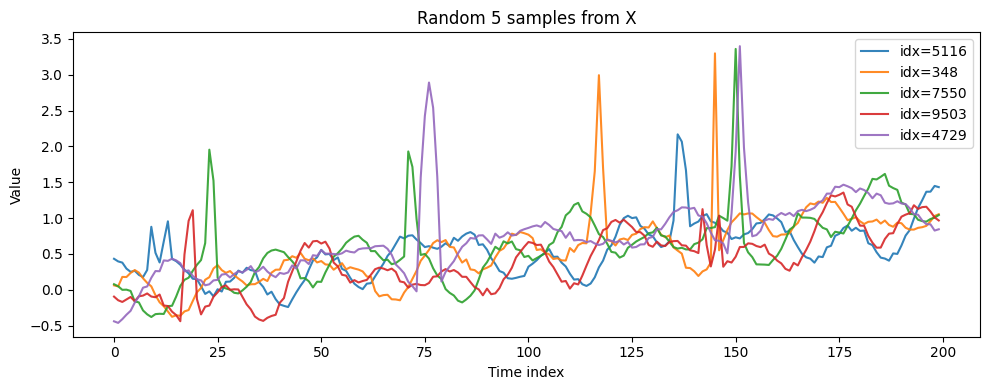

In [4]:
plot_toy_dataset(X,random_state = 1,num=5)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_components_3(trend, season, extreme, random_state=0, num=5):
    """
    trend/season/extreme: (N, T, 1)
    """
    N, T, _ = trend.shape
    rng = np.random.default_rng(random_state)

    num = min(num, N)
    idx = rng.choice(N, size=num, replace=False)
    x = np.arange(T)

    # --- 1) Trend ---
    plt.figure(figsize=(10, 3.2))
    for i in idx:
        plt.plot(x, trend[i, :, 0], alpha=0.9, label=f"idx={i}")
    plt.title(f"Trend (random {num} samples)")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 2) Seasonality ---
    plt.figure(figsize=(10, 3.2))
    for i in idx:
        plt.plot(x, season[i, :, 0], alpha=0.9, label=f"idx={i}")
    plt.title(f"Seasonality (random {num} samples)")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 3) Extreme ---
    plt.figure(figsize=(10, 3.2))
    for i in idx:
        plt.plot(x, extreme[i, :, 0], alpha=0.9, label=f"idx={i}")
    plt.title(f"Extreme (random {num} samples)")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

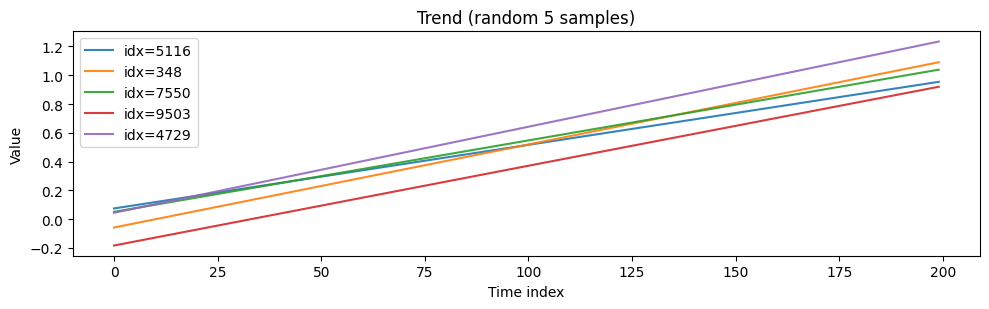

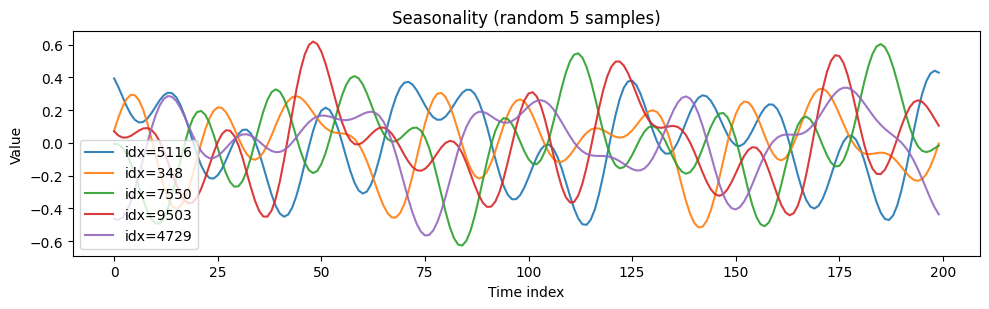

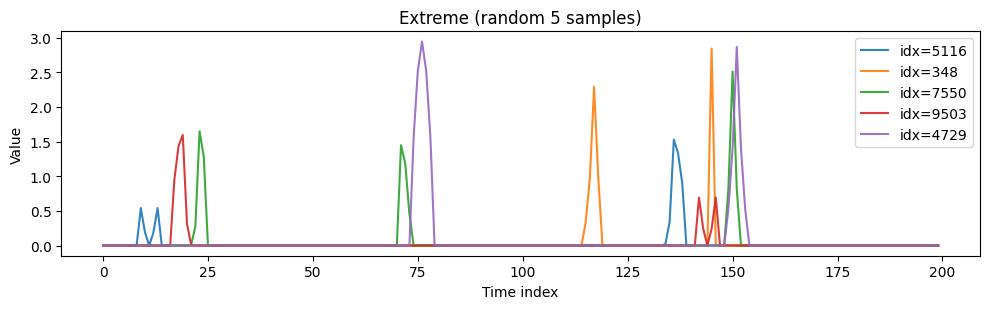

In [6]:
plot_components_3(trend, season, extreme, random_state=1, num=5)

In [7]:
import numpy as np

# ---------- Trend: intercept & slope (fit y = b + a * u, u=t/(T-1)) ----------
def fit_trend(trend):
    N, T, _ = trend.shape
    y = trend[:, :, 0].astype(np.float64)           # (N, T)
    u = np.linspace(0.0, 1.0, T, dtype=np.float64)  # normalized time

    u_mean = u.mean()
    u_center = u - u_mean
    denom = (u_center ** 2).sum() + 1e-12

    y_mean = y.mean(axis=1, keepdims=True)
    slope = ((y - y_mean) * u_center[None, :]).sum(axis=1) / denom
    intercept = y_mean[:, 0] - slope * u_mean
    return intercept.astype(np.float32), slope.astype(np.float32)


# ---------- Seasonality: top-k freqs by energy from rFFT ----------
def topk_season_freqs(season, topk=3):
    N, T, _ = season.shape
    y = season[:, :, 0].astype(np.float64)          # (N, T)
    Y = np.fft.rfft(y, axis=1)                      # (N, T//2+1)
    energy = (np.abs(Y) ** 2)
    energy[:, 0] = -np.inf                          # exclude DC

    idx = np.argpartition(energy, -topk, axis=1)[:, -topk:]  # unsorted topk
    row = np.arange(N)[:, None]
    idx = idx[row, np.argsort(energy[row, idx], axis=1)[:, ::-1]]  # sort desc

    return idx.astype(np.int32), energy[row, idx].astype(np.float32)


# ---------- summaries ----------
def summarize(name, arr):
    arr = np.asarray(arr)
    q = np.quantile(arr, [0.0, 0.25, 0.5, 0.75, 0.95, 1.0])
    print(f"{name}: mean={arr.mean():.4g}, std={arr.std():.4g}, "
          f"min={q[0]:.4g}, p25={q[1]:.4g}, p50={q[2]:.4g}, p75={q[3]:.4g}, p95={q[4]:.4g}, max={q[5]:.4g}")


def report_trend_season(trend_all, season_all, random_state=0, num=5, topk=3):
    N = trend_all.shape[0]
    rng = np.random.default_rng(random_state)
    idx5 = rng.choice(N, size=min(num, N), replace=False)

    # compute all
    intercept, slope = fit_trend(trend_all)
    top_bins, top_energy = topk_season_freqs(season_all, topk=topk)

    # ---- (A) random 5 samples detailed ----
    print("===== Random samples (detailed) =====")
    for i in idx5:
        bins = top_bins[i].tolist()
        eng  = top_energy[i].tolist()
        print(f"idx={i:4d} | trend: intercept={intercept[i]: .4f}, slope={slope[i]: .4f} | "
              f"season top{topk}: " +
              ", ".join([f"k={b} (E={e:.3g})" for b, e in zip(bins, eng)]))

    # ---- (B) overall distribution stats ----
    print("\n===== Overall distribution (trend) =====")
    summarize("trend intercept", intercept)
    summarize("trend slope", slope)

    print("\n===== Overall distribution (season top bins) =====")
    all_bins = top_bins.reshape(-1)
    uniq, cnt = np.unique(all_bins, return_counts=True)
    order = np.argsort(cnt)[::-1]
    print("Most common bins among top-k (count = occurrences over N*topk):")
    for u, c in zip(uniq[order][:15], cnt[order][:15]):
        print(f"  k={int(u):3d}: {int(c)}")

    print("\nSeason top-1 energy distribution:")
    summarize("season top1 energy", top_energy[:, 0])

In [8]:
 report_trend_season(trend, season, random_state=0, num=5, topk=3)

===== Random samples (detailed) =====
idx=6367 | trend: intercept= 0.1225, slope= 0.9261 | season top3: k=3 (E=497), k=11 (E=373), k=5 (E=181)
idx=5110 | trend: intercept= 0.1544, slope= 0.8735 | season top3: k=8 (E=450), k=3 (E=211), k=5 (E=146)
idx=2697 | trend: intercept=-0.1492, slope= 1.1094 | season top3: k=11 (E=392), k=8 (E=301), k=5 (E=273)
idx=3078 | trend: intercept= 0.0840, slope= 1.0220 | season top3: k=5 (E=489), k=3 (E=384), k=11 (E=272)
idx=8502 | trend: intercept= 0.0061, slope= 0.9192 | season top3: k=8 (E=396), k=3 (E=324), k=5 (E=183)

===== Overall distribution (trend) =====
trend intercept: mean=-0.001512, std=0.1151, min=-0.1999, p25=-0.1016, p50=-0.003115, p75=0.09802, p95=0.1792, max=0.2
trend slope: mean=1, std=0.1157, min=0.8001, p25=0.9004, p50=0.9992, p75=1.101, p95=1.18, max=1.2

===== Overall distribution (season top bins) =====
Most common bins among top-k (count = occurrences over N*topk):
  k=  5: 7558
  k=  3: 7534
  k= 11: 7454
  k=  8: 7454

Season 

In [9]:
import numpy as np

def summarize(name, arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        print(f"{name}: empty")
        return
    q = np.quantile(arr, [0.0, 0.25, 0.5, 0.75, 0.95, 1.0])
    print(f"{name}: mean={arr.mean():.4g}, std={arr.std():.4g}, "
          f"min={q[0]:.4g}, p25={q[1]:.4g}, p50={q[2]:.4g}, p75={q[3]:.4g}, p95={q[4]:.4g}, max={q[5]:.4g}")

def extract_events_1d_merged(x, eps=1e-8, merge_gap=1):
    """
    x: (T,) extreme
    eps: event point threshold
    merge_gap: if next segment starts within <= merge_gap points after current ends,
               then merge them into one event.
    returns list of (l, r) inclusive
    """
    mask = np.abs(x) > eps
    if not np.any(mask):
        return []

    idx = np.where(mask)[0]
    segs = []
    l = idx[0]
    prev = idx[0]
    for j in idx[1:]:
        if j == prev + 1:
            prev = j
        else:
            segs.append((l, prev))
            l = j
            prev = j
    segs.append((l, prev))

    # merge by gap
    merged = []
    cur_l, cur_r = segs[0]
    for l, r in segs[1:]:
        if l - cur_r - 1 <= merge_gap:
            cur_r = r  # bridge small gap
        else:
            merged.append((cur_l, cur_r))
            cur_l, cur_r = l, r
    merged.append((cur_l, cur_r))
    return merged


def extreme_stats(extreme_all, eps=1e-8, merge_gap=1):
    """
    extreme_all: (N,T,1)
    return per_sample, per_event, events_by_sample (same format as before)
    """
    N, T, _ = extreme_all.shape

    event_count = np.zeros(N, dtype=np.int32)
    coverage_points = np.zeros(N, dtype=np.int32)
    peak_abs = np.zeros(N, dtype=np.float32)
    energy = np.zeros(N, dtype=np.float32)

    E_loc, E_width, E_peak, E_energy, E_l, E_r = [], [], [], [], [], []
    events_by_sample = []

    for i in range(N):
        x = extreme_all[i, :, 0].astype(np.float64)
        events = extract_events_1d_merged(x, eps=eps, merge_gap=merge_gap)

        mask = np.abs(x) > eps
        event_count[i] = len(events)
        coverage_points[i] = int(mask.sum())  # still true non-zero coverage
        peak_abs[i] = float(np.max(np.abs(x))) if mask.any() else 0.0
        energy[i] = float(np.sum(x * x))

        cur = []
        for (l, r) in events:
            seg = x[l:r+1]
            width = r - l + 1
            center = int(l + np.argmax(np.abs(seg)))
            pk = float(np.max(np.abs(seg)))
            en = float(np.sum(seg * seg))

            cur.append({"l": int(l), "r": int(r), "width": int(width),
                        "center": int(center), "peak_abs": pk, "energy": en})

            E_l.append(int(l)); E_r.append(int(r))
            E_loc.append(center); E_width.append(width)
            E_peak.append(pk); E_energy.append(en)

        events_by_sample.append(cur)

    per_sample = {
        "event_count": event_count,
        "coverage_points": coverage_points,
        "coverage_ratio": coverage_points.astype(np.float32) / float(T),
        "peak_abs": peak_abs,
        "energy": energy,
    }
    per_event = {
        "l": np.array(E_l, dtype=np.int32),
        "r": np.array(E_r, dtype=np.int32),
        "loc": np.array(E_loc, dtype=np.int32),
        "width": np.array(E_width, dtype=np.int32),
        "peak_abs": np.array(E_peak, dtype=np.float32),
        "energy": np.array(E_energy, dtype=np.float32),
    }
    return per_sample, per_event, events_by_sample

def report_extreme(extreme_all, random_state=0, num=5, eps=1e-8):
    N, T, _ = extreme_all.shape
    rng = np.random.default_rng(random_state)
    idx = rng.choice(N, size=min(num, N), replace=False)

    per_sample, per_event, events_by_sample = extreme_stats(extreme_all, eps=eps)

    # ---- (A) random 5 samples detailed ----
    print("===== Random samples (detailed) =====")
    for i in idx:
        print(f"idx={i} | count={per_sample['event_count'][i]} | "
              f"coverage={per_sample['coverage_points'][i]}/{T} ({per_sample['coverage_ratio'][i]:.3f}) | "
              f"peak_abs={per_sample['peak_abs'][i]:.4g} | energy={per_sample['energy'][i]:.4g}")
        for j, ev in enumerate(events_by_sample[i]):
            print(f"  event{j}: [l={ev['l']}, r={ev['r']}], width={ev['width']}, "
                  f"center={ev['center']}, peak_abs={ev['peak_abs']:.4g}, energy={ev['energy']:.4g}")

    # ---- (B) overall distribution stats ----
    print("\n===== Overall distribution (per-sample) =====")
    summarize("event_count", per_sample["event_count"])
    summarize("coverage_points", per_sample["coverage_points"])
    summarize("coverage_ratio", per_sample["coverage_ratio"])
    summarize("peak_abs", per_sample["peak_abs"])
    summarize("energy", per_sample["energy"])

    print("\n===== Overall distribution (per-event) =====")
    summarize("event_width", per_event["width"])
    summarize("event_loc", per_event["loc"])
    summarize("event_peak_abs", per_event["peak_abs"])
    summarize("event_energy", per_event["energy"])

    # 位置最常见的 center（可快速看“规律性”是否集中在某些区间）
    if per_event["loc"].size > 0:
        uniq, cnt = np.unique(per_event["loc"], return_counts=True)
        order = np.argsort(cnt)[::-1]
        print("\nMost common event centers (top 10):")
        for u, c in zip(uniq[order][:10], cnt[order][:10]):
            print(f"  t={int(u)}: {int(c)}")

In [10]:
report_extreme(extreme, random_state=0, num=5, eps=1e-8)

===== Random samples (detailed) =====
idx=6367 | count=3 | coverage=10/200 (0.050) | peak_abs=2.308 | energy=16.22
  event0: [l=43, r=45], width=3, center=43, peak_abs=2.308, energy=8.973
  event1: [l=96, r=98], width=3, center=97, peak_abs=2.139, energy=4.577
  event2: [l=172, r=175], width=4, center=174, peak_abs=1.301, energy=2.668
idx=5110 | count=2 | coverage=7/200 (0.035) | peak_abs=2.064 | energy=12.03
  event0: [l=7, r=9], width=3, center=9, peak_abs=2.064, energy=6.898
  event1: [l=59, r=62], width=4, center=62, peak_abs=1.807, energy=5.133
idx=2697 | count=3 | coverage=10/200 (0.050) | peak_abs=3.803 | energy=24.31
  event0: [l=30, r=31], width=2, center=31, peak_abs=3.803, energy=18.87
  event1: [l=102, r=104], width=3, center=103, peak_abs=1.01, energy=1.389
  event2: [l=156, r=160], width=5, center=158, peak_abs=1.543, energy=4.052
idx=3078 | count=2 | coverage=9/200 (0.045) | peak_abs=2.058 | energy=12.96
  event0: [l=19, r=23], width=5, center=21, peak_abs=2.058, energy=

### extreme detection methods

In [11]:
import numpy as np


# ============================================================
# Config (script-friendly defaults)
# ============================================================
SEASON_BINS_DEFAULT = (3, 5, 8, 11)


# ============================================================
# 1) Background fit (trend + fixed season bins) and residual
#    Use precomputed pseudo-inverse to speed up (pinv(A) @ x).
# ============================================================
def build_design_matrix(T, season_bins=SEASON_BINS_DEFAULT):
    t = np.arange(T, dtype=np.float32)
    x = t / float(T - 1)

    cols = [np.ones(T, dtype=np.float32), x.astype(np.float32)]
    for k in season_bins:
        ang = 2.0 * np.pi * k * t / float(T)
        cols.append(np.sin(ang).astype(np.float32))
        cols.append(np.cos(ang).astype(np.float32))

    A = np.stack(cols, axis=1)  # (T, D)
    return A


def precompute_bg_solver(A):
    """
    Precompute pinv(A) for fast per-sample background fitting.
    """
    pinvA = np.linalg.pinv(A)  # (D, T)
    return pinvA


def fit_background_and_residual(x_1d, A, pinvA=None):
    """
    x_1d: (T,)
    A: (T, D)
    pinvA: (D, T) optional for speed
    returns: bg_hat (T,), residual (T,)
    """
    if pinvA is None:
        coef, _, _, _ = np.linalg.lstsq(A, x_1d, rcond=None)
    else:
        coef = pinvA @ x_1d  # (D,)
    bg_hat = A @ coef
    residual = x_1d - bg_hat
    return bg_hat, residual


# ============================================================
# 2) Short-window score
#    score_mode:
#      - "energy": sum(max(r,0)^2) in window, favors sharp/high events
#      - "area"  : sum(max(r,0))   in window, tends to recover weaker events
# ============================================================
def sliding_pos_score(residual, L=5, score_mode="energy"):
    """
    residual: (T,)
    score[c] computed for c in [half, T-half-1], else 0
    """
    T = residual.shape[0]
    half = L // 2
    score = np.zeros(T, dtype=np.float32)

    rp = np.maximum(residual, 0.0)

    if score_mode not in ("energy", "area"):
        raise ValueError(f"Unknown score_mode: {score_mode}")

    for c in range(half, T - half):
        seg = rp[c - half : c + half + 1]
        if score_mode == "energy":
            score[c] = np.sum(seg * seg).astype(np.float32)
        else:
            score[c] = np.sum(seg).astype(np.float32)
    return score


def find_local_peaks(score):
    """
    Simple local peaks: score[i-1] < score[i] >= score[i+1]
    returns indices of peaks
    """
    T = len(score)
    if T < 3:
        return np.array([], dtype=int)

    peaks = []
    for i in range(1, T - 1):
        if score[i - 1] < score[i] and score[i] >= score[i + 1]:
            peaks.append(i)
    return np.array(peaks, dtype=int)


def select_centers_nms(score, thr, min_gap=10, max_events=4):
    """
    1) find local peaks above thr
    2) sort by score descending
    3) NMS with min_gap
    """
    peaks = find_local_peaks(score)
    peaks = peaks[score[peaks] >= thr]

    if len(peaks) == 0:
        return np.array([], dtype=int)

    order = np.argsort(score[peaks])[::-1]
    peaks_sorted = peaks[order]

    selected = []
    for p in peaks_sorted:
        ok = True
        for s in selected:
            if abs(p - s) < min_gap:
                ok = False
                break
        if ok:
            selected.append(int(p))
        if len(selected) >= max_events:
            break

    return np.array(selected, dtype=int)


def centers_to_events(residual, centers, L=5):
    """
    Create event list from centers with fixed window length L.
    Each event is a dict with l,r,center,peak,peak_pos,energy,area
    """
    T = len(residual)
    half = L // 2
    rp = np.maximum(residual, 0.0)

    events = []
    for c in centers:
        l = max(0, c - half)
        r = min(T - 1, c + half)

        seg_r = residual[l : r + 1]
        seg_rp = rp[l : r + 1]

        peak_pos_local = int(np.argmax(seg_r))
        peak_pos = l + peak_pos_local
        peak = float(seg_r[peak_pos_local])

        energy = float(np.sum(seg_rp * seg_rp))
        area = float(np.sum(seg_rp))

        events.append(
            {
                "l": int(l),
                "r": int(r),
                "center": int(c),
                "peak": peak,
                "peak_pos": int(peak_pos),
                "energy": energy,
                "area": area,
            }
        )
    return events


# ============================================================
# 3) Ground-truth events from extreme_all (origin only)
#    Important: avoid splitting one event into two due to exact zeros.
# ============================================================
def gt_events_from_extreme(extreme_1d, eps=1e-6, merge_gap=1):
    """
    extreme_1d: (T,) nonnegative, nonzero on event supports
    eps: treat <= eps as 0
    merge_gap: merge tiny gaps inside an event, merge_gap=1 is usually enough
    return list of dicts with l,r,center,peak,energy,area
    center uses argmax within the segment for better alignment.
    """
    T = len(extreme_1d)
    mask = extreme_1d > eps
    if not np.any(mask):
        return []

    # merge gaps of length <= merge_gap
    if merge_gap > 0:
        # simple gap fill: for each false run of length <= merge_gap between trues, fill it
        i = 0
        while i < T:
            if mask[i]:
                i += 1
                continue
            j = i
            while j < T and (not mask[j]):
                j += 1
            # gap is [i, j-1]
            gap_len = j - i
            left_true = (i - 1 >= 0) and mask[i - 1]
            right_true = (j < T) and mask[j]
            if left_true and right_true and gap_len <= merge_gap:
                mask[i:j] = True
            i = j

    events = []
    i = 0
    while i < T:
        if not mask[i]:
            i += 1
            continue
        l = i
        while i + 1 < T and mask[i + 1]:
            i += 1
        r = i

        seg = extreme_1d[l : r + 1]
        peak_pos_local = int(np.argmax(seg))
        peak_pos = l + peak_pos_local
        peak = float(seg[peak_pos_local])

        energy = float(np.sum(seg * seg))
        area = float(np.sum(seg))

        events.append(
            {
                "l": int(l),
                "r": int(r),
                "center": int(peak_pos),
                "peak": peak,
                "peak_pos": int(peak_pos),
                "energy": energy,
                "area": area,
            }
        )
        i += 1

    return events


# ============================================================
# 4) Event matching and metrics
# ============================================================
def match_by_center(pred_events, gt_events, delta=2):
    """
    Greedy one-to-one matching by descending pred energy.
    """
    if len(pred_events) == 0 or len(gt_events) == 0:
        return [], list(range(len(pred_events))), list(range(len(gt_events)))

    pred_order = np.argsort([e["energy"] for e in pred_events])[::-1]
    gt_used = np.zeros(len(gt_events), dtype=bool)

    matches = []
    for pi in pred_order:
        pc = pred_events[pi]["center"]

        best_gi = None
        best_dist = None
        for gi, g in enumerate(gt_events):
            if gt_used[gi]:
                continue
            dist = abs(pc - g["center"])
            if dist <= delta:
                if best_dist is None or dist < best_dist:
                    best_dist = dist
                    best_gi = gi

        if best_gi is not None:
            gt_used[best_gi] = True
            matches.append((int(pi), int(best_gi)))

    matched_pred = set(pi for pi, _ in matches)
    matched_gt = set(gi for _, gi in matches)

    unmatched_pred = [i for i in range(len(pred_events)) if i not in matched_pred]
    unmatched_gt = [i for i in range(len(gt_events)) if i not in matched_gt]
    return matches, unmatched_pred, unmatched_gt


def compute_metrics(pred_events, gt_events, matches):
    tp = len(matches)
    fp = len(pred_events) - tp
    fn = len(gt_events) - tp

    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    center_err = []
    peak_err = []
    energy_rel_err = []

    for pi, gi in matches:
        p = pred_events[pi]
        g = gt_events[gi]

        center_err.append(abs(p["center"] - g["center"]))
        peak_err.append(abs(p["peak"] - g["peak"]))

        denom = abs(g["energy"]) + 1e-12
        energy_rel_err.append(abs(p["energy"] - g["energy"]) / denom)

    out = {
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "center_err_p50": float(np.percentile(center_err, 50)) if center_err else None,
        "center_err_p95": float(np.percentile(center_err, 95)) if center_err else None,
        "peak_err_mean": float(np.mean(peak_err)) if peak_err else None,
        "energy_rel_err_mean": float(np.mean(energy_rel_err)) if energy_rel_err else None,
    }
    return out


# ============================================================
# 5) Threshold calibration on origin (uses ground truth)
#    Strategy: prefer recall >= target_recall, then maximize precision.
#    Fallback: best F1 if target_recall cannot be achieved.
# ============================================================
def calibrate_threshold_origin(
    X,
    extreme_all,
    A,
    pinvA=None,
    L=5,
    min_gap=10,
    max_events=4,
    delta=2,
    score_mode="energy",
    gt_eps=1e-6,
    gt_merge_gap=1,
    q_grid=None,
    target_recall=0.85,
    calib_max_samples=1500,
    rng_seed=0,
):
    rng = np.random.default_rng(rng_seed)
    N, T, _ = X.shape

    # calibration subset for speed
    N_calib = min(N, int(calib_max_samples))
    idx_calib = rng.choice(N, size=N_calib, replace=False)

    pos_scores = []
    neg_scores = []

    for i in idx_calib:
        x = X[i, :, 0]
        extreme = extreme_all[i, :, 0]

        _, r = fit_background_and_residual(x, A, pinvA=pinvA)
        score = sliding_pos_score(r, L=L, score_mode=score_mode)

        gt_events = gt_events_from_extreme(extreme, eps=gt_eps, merge_gap=gt_merge_gap)
        gt_centers = {e["center"] for e in gt_events}

        for c in gt_centers:
            pos_scores.append(float(score[c]))

        candidates = np.arange(L // 2, T - L // 2, dtype=int)
        candidates = np.array([c for c in candidates if c not in gt_centers], dtype=int)
        if len(candidates) > 0:
            m = min(len(candidates), max(10, 3 * len(gt_centers) + 5))
            neg_cs = rng.choice(candidates, size=m, replace=False)
            neg_scores.extend([float(score[c]) for c in neg_cs])

    pos_scores = np.array(pos_scores, dtype=np.float32)
    neg_scores = np.array(neg_scores, dtype=np.float32)

    if q_grid is None:
        # lower-biased range tends to improve recall
        q_grid = np.linspace(0.85, 0.99, 15)

    # thresholds from NEG distribution, easier to control FP
    if len(neg_scores) == 0:
        raise RuntimeError("neg_scores is empty, cannot calibrate threshold.")
    neg_scores_sorted = np.sort(neg_scores)

    best = {"thr": None, "precision": -1.0, "recall": -1.0, "f1": -1.0, "q": None}
    best_fallback = {"thr": None, "precision": -1.0, "recall": -1.0, "f1": -1.0, "q": None}

    for q in q_grid:
        thr = float(np.quantile(neg_scores_sorted, q))

        all_f1 = []
        all_p = []
        all_r = []

        # evaluate on same calibration subset (fast enough, consistent)
        for i in idx_calib:
            x = X[i, :, 0]
            extreme = extreme_all[i, :, 0]

            _, r = fit_background_and_residual(x, A, pinvA=pinvA)
            score = sliding_pos_score(r, L=L, score_mode=score_mode)

            centers = select_centers_nms(score, thr=thr, min_gap=min_gap, max_events=max_events)
            pred_events = centers_to_events(r, centers, L=L)
            gt_events = gt_events_from_extreme(extreme, eps=gt_eps, merge_gap=gt_merge_gap)

            matches, _, _ = match_by_center(pred_events, gt_events, delta=delta)
            m = compute_metrics(pred_events, gt_events, matches)

            all_f1.append(m["f1"])
            all_p.append(m["precision"])
            all_r.append(m["recall"])

        p_mean = float(np.mean(all_p))
        r_mean = float(np.mean(all_r))
        f1_mean = float(np.mean(all_f1))

        # fallback: best F1
        if f1_mean > best_fallback["f1"]:
            best_fallback = {"thr": thr, "precision": p_mean, "recall": r_mean, "f1": f1_mean, "q": float(q)}

        # main: prioritize recall then precision
        if r_mean >= target_recall:
            if (best["thr"] is None) or (p_mean > best["precision"]):
                best = {"thr": thr, "precision": p_mean, "recall": r_mean, "f1": f1_mean, "q": float(q)}

    if best["thr"] is None:
        best = best_fallback
    return best


# ============================================================
# 6) Run extraction and evaluation on origin using calibrated threshold
# ============================================================
def run_origin_extract_and_eval(
    X,
    extreme_all,
    L=5,
    min_gap=10,
    max_events=4,
    delta=2,
    score_mode="energy",
    gt_eps=1e-6,
    gt_merge_gap=1,
    target_recall=0.85,
    calib_max_samples=1500,
    rng_seed=0,
):
    N, T, _ = X.shape
    A = build_design_matrix(T, season_bins=SEASON_BINS_DEFAULT)
    pinvA = precompute_bg_solver(A)

    best = calibrate_threshold_origin(
        X,
        extreme_all,
        A,
        pinvA=pinvA,
        L=L,
        min_gap=min_gap,
        max_events=max_events,
        delta=delta,
        score_mode=score_mode,
        gt_eps=gt_eps,
        gt_merge_gap=gt_merge_gap,
        target_recall=target_recall,
        calib_max_samples=calib_max_samples,
        rng_seed=rng_seed,
    )
    thr = best["thr"]

    metrics_list = []
    pred_counts = []
    gt_counts = []

    for i in range(N):
        x = X[i, :, 0]
        extreme = extreme_all[i, :, 0]

        _, r = fit_background_and_residual(x, A, pinvA=pinvA)
        score = sliding_pos_score(r, L=L, score_mode=score_mode)

        centers = select_centers_nms(score, thr=thr, min_gap=min_gap, max_events=max_events)
        pred_events = centers_to_events(r, centers, L=L)
        gt_events = gt_events_from_extreme(extreme, eps=gt_eps, merge_gap=gt_merge_gap)

        matches, _, _ = match_by_center(pred_events, gt_events, delta=delta)
        m = compute_metrics(pred_events, gt_events, matches)

        metrics_list.append(m)
        pred_counts.append(len(pred_events))
        gt_counts.append(len(gt_events))

    f1s = np.array([m["f1"] for m in metrics_list], dtype=np.float32)
    ps = np.array([m["precision"] for m in metrics_list], dtype=np.float32)
    rs = np.array([m["recall"] for m in metrics_list], dtype=np.float32)

    summary = {
        "calibrated_thr": float(thr),
        "calib_q": float(best.get("q", np.nan)),
        "calib_precision": float(best.get("precision", np.nan)),
        "calib_recall": float(best.get("recall", np.nan)),
        "calib_f1": float(best.get("f1", np.nan)),
        "avg_precision": float(np.mean(ps)),
        "avg_recall": float(np.mean(rs)),
        "avg_f1": float(np.mean(f1s)),
        "pred_count_mean": float(np.mean(pred_counts)),
        "gt_count_mean": float(np.mean(gt_counts)),
        "score_mode": str(score_mode),
        "target_recall": float(target_recall),
        "gt_eps": float(gt_eps),
        "gt_merge_gap": int(gt_merge_gap),
    }
    return summary, metrics_list, best

def print_summary(summary, title="=== Origin extraction eval (event-level) ==="):
    """
    Pretty-print the summary dict returned by run_origin_extract_and_eval.
    Handles None / NaN / missing keys gracefully.
    """
    def fmt(v):
        if v is None:
            return "None"
        # numpy scalars
        if isinstance(v, (np.floating, float)):
            if np.isnan(v):
                return "NaN"
            return f"{float(v):.6g}"  # compact float
        if isinstance(v, (np.integer, int)):
            return str(int(v))
        # strings / other
        return str(v)

    print(title)

    # preferred key order (prints those found; then prints remaining keys)
    key_order = [
        "calibrated_thr",
        "calib_q",
        "calib_precision",
        "calib_recall",
        "calib_f1",
        "avg_precision",
        "avg_recall",
        "avg_f1",
        "pred_count_mean",
        "gt_count_mean",
        "score_mode",
        "target_recall",
        "gt_eps",
        "gt_merge_gap",
    ]

    printed = set()

    for k in key_order:
        if k in summary:
            print(f"{k}: {fmt(summary[k])}")
            printed.add(k)

    # print any extra keys not in key_order
    extra_keys = [k for k in summary.keys() if k not in printed]
    if extra_keys:
        for k in sorted(extra_keys):
            print(f"{k}: {fmt(summary[k])}")


# ============================================================
# Example usage
# ============================================================
if __name__ == "__main__":
    # You should already have:
    #   X: (N, T, 1)
    #   extreme_all: (N, T, 1)
    #
    # Example:
    # X, trend_all, season_all, ref_all, extreme_all, noise_all = generate_toy_dataset_v2_cofreq(
    #     N=10000, T=200, seed=0, return_components=True
    # )

    # IMPORTANT: use extreme_all, not a single extreme vector.
    summary, metrics_list, calib = run_origin_extract_and_eval(X, extreme)
    print_summary(summary)

=== Origin extraction eval (event-level) ===
calibrated_thr: 0.10131
calib_q: 0.93
calib_precision: 0.885222
calib_recall: 0.8535
calib_f1: 0.841156
avg_precision: 0.885442
avg_recall: 0.843658
avg_f1: 0.83636
pred_count_mean: 2.4629
gt_count_mean: 2.4763
score_mode: energy
target_recall: 0.85
gt_eps: 1e-06
gt_merge_gap: 1


In [33]:
L = 200
N = 10000
X = X.reshape(-1,1)
np.save(f"top_example_seq_{L}_sample_{N}.npy", X)